In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  torchvision import datasets , transforms

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
])
training_dataset = datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,
                                              batch_size=32,
                                              shuffle=True)

validation_dataset = datasets.MNIST(root='./data',
                                    train=False,
                                    download=True,
                                    transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=32,
                                                shuffle=True)

In [11]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    return image

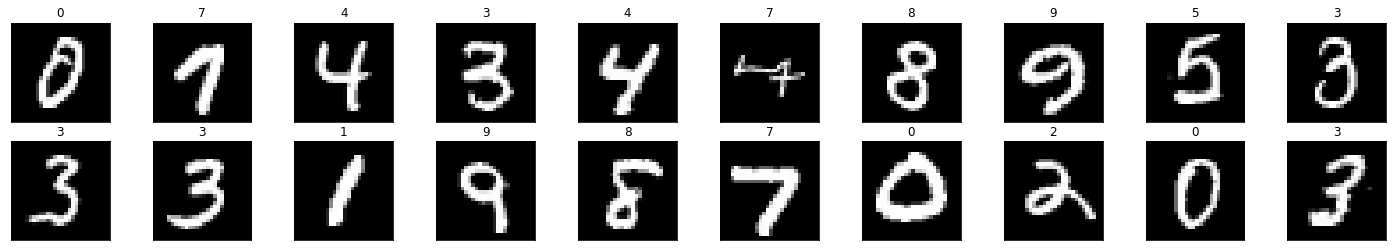

In [12]:
dataiter = iter(training_loader)
images , labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(labels[i].item())

In [13]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super(Classifier,self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        

In [14]:
torch.manual_seed(2)
model = Classifier(28*28,125,65,10)
print(model)

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [16]:
epochs = 12
running_loss_history = []
running_correct_history = []

val_running_loss_history = []
val_running_correct_history = []
for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs , val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()
            
        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_accuracy)
        print('Training Loss: {:.4f} {:.4f}'.format(epoch_loss,
                                                    epoch_accuracy.item()))
        
        val_epoch_loss = running_loss / len(validation_loader)
        val_epoch_accuracy = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_accuracy)
        print('Validation Loss: {:.4f} {:.4f}'.format(val_epoch_loss,
                                                    val_epoch_accuracy.item()))

Training Loss: 0.3539 28.5627
Validation Loss: 2.1199 29.8339
Training Loss: 0.1688 30.3360
Validation Loss: 1.0111 30.4824
Training Loss: 0.1292 30.7285
Validation Loss: 0.7742 30.9553
Training Loss: 0.1071 30.9179
Validation Loss: 0.6416 30.7540
Training Loss: 0.0943 31.0432
Validation Loss: 0.5652 30.7029
Training Loss: 0.0824 31.1600
Validation Loss: 0.4935 30.9297
Training Loss: 0.0741 31.2267
Validation Loss: 0.4436 31.0288
Training Loss: 0.0684 31.2859
Validation Loss: 0.4095 31.0575
Training Loss: 0.0604 31.3733
Validation Loss: 0.3620 30.8403
Training Loss: 0.0575 31.3669
Validation Loss: 0.3444 30.9169
Training Loss: 0.0540 31.4320
Validation Loss: 0.3234 30.9840
Training Loss: 0.0489 31.4832
Validation Loss: 0.2930 31.1086


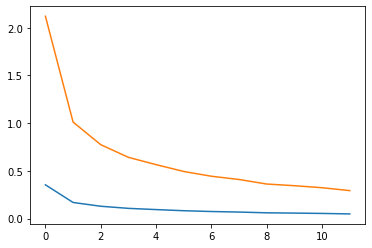

In [17]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')